## Case Study: Ride Sharing Analysis

This data set is a masked and simplified data set which is like what data analysts at Uber/Lyft handle. 

### Business Understanding

You may have some experience of traveling to and from the airport. Have you ever used Uber/Lyft or any other cab service for this trip? Did you ‌face the problem of cancellation by the driver or non-availability of cars?
These problems also affect the ride companies, as their revenue is tied to the trips made. 
We will investigate this problem of non availability and cancellation 

### Business Objectives

The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to improve the situation. 
As a result of your analysis, you should be able to highlight the root cause(s) and possible hypotheses of the problem(s) and recommend ways to improve them.

### Data download

https://raw.githubusercontent.com/vkoul/data/main/misc/ride_data.csv

### Data Dictionary

There are six attributes associated with each request made by a customer:

- Request id: A unique identifier of the request 
- Pick-up point: The point from which the request was made 
- Driver id: The unique identification number of the driver 
- Status: The final status of the trip, that can be either completed, canceled by the driver or no cars available
- Request Time Stamp: The date and time at which the customer made the trip request 
- Drop Time Stamp: The drop-off date and time, in case the trip was completed

### Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
url = "https://raw.githubusercontent.com/vkoul/data/main/misc/ride_data.csv"
df = pd.read_csv(url,parse_dates=["Request timestamp","Drop timestamp"])
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,1,Airport,285.0,Trip Completed,2016-11-07 00:20:00,2016-11-07 00:51:00
1,2,Airport,NaN,No Cars Available,2016-11-07 00:23:00,NaT
2,3,Airport,80.0,Trip Completed,2016-11-07 00:24:00,2016-11-07 01:31:00
3,4,City,NaN,No Cars Available,2016-11-07 00:37:00,NaT
4,5,Airport,264.0,Trip Completed,2016-11-07 00:36:00,2016-11-07 01:35:00


### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Request id         6745 non-null   int64         
 1   Pickup point       6745 non-null   object        
 2   Driver id          4095 non-null   float64       
 3   Status             6745 non-null   object        
 4   Request timestamp  6745 non-null   datetime64[ns]
 5   Drop timestamp     2831 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.3+ KB


In [4]:
df.describe(include="object")

,Pickup point,Status
count,6745,6745
unique,2,3
top,City,Trip Completed
freq,3507,2831


In [5]:
df.isna().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

##### Do "NA" values only relate to rides that were not completed?

In [6]:
df[df["Driver id"].isna()].groupby(by="Status").count()

,Request id,Pickup point,Driver id,Request timestamp,Drop timestamp
Status,,,,,
No Cars Available,2650,2650,0,2650,0


In [7]:
df[df["Drop timestamp"].isna()].groupby(by=df.Status).count()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
Status,,,,,,
Cancelled,1264,1264,1264,1264,1264,0
No Cars Available,2650,2650,0,2650,2650,0


Indeed, "NA" values all relate to rides that were not completed. "Driver id" only is "NA" if no car was available, and "Drop timestamps" are "NA" when either no car was available or the driver cancelled the trip.

##### Additional columns that may prove useful for our analysis: month, week, weekday, hour of request, as well as length of ride (if completed)

We will first check the date range for requests:

In [8]:
print(df["Request timestamp"].min())
print(df["Request timestamp"].max())

2016-07-13 00:00:00
2016-12-07 23:54:00


The data only covers c. 5 months. Hence monthly summaries may not be very relevant, but we will include these in our analysis for completeness.

In [9]:
df["Month"] = df["Request timestamp"].dt.month
df["Week"] = df["Request timestamp"].dt.week
df["Weekday"] = df["Request timestamp"].dt.weekday
df["Hour"] = df["Request timestamp"].dt.hour
df["Ride length"] = df["Drop timestamp"] - df["Request timestamp"]

In [10]:
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Month,Week,Weekday,Hour,Ride length
0,1,Airport,285.0,Trip Completed,2016-11-07 00:20:00,2016-11-07 00:51:00,11,45,0,0,0 days 00:31:00
1,2,Airport,NaN,No Cars Available,2016-11-07 00:23:00,NaT,11,45,0,0,NaT
2,3,Airport,80.0,Trip Completed,2016-11-07 00:24:00,2016-11-07 01:31:00,11,45,0,0,0 days 01:07:00
3,4,City,NaN,No Cars Available,2016-11-07 00:37:00,NaT,11,45,0,0,NaT
4,5,Airport,264.0,Trip Completed,2016-11-07 00:36:00,2016-11-07 01:35:00,11,45,0,0,0 days 00:59:00


In [11]:
df.describe()

,Request id,Driver id,Month,Week,Weekday,Hour,Ride length
count,6745.000000,4095.000000,6745.000000,6745.000000,6745.000000,6745.000000,2831
mean,3384.644922,149.501343,8.779540,35.514603,2.204744,12.956709,-1 days +13:14:01.759095726
std,1955.099667,86.051994,2.218331,9.357827,1.337382,6.504052,10 days 07:07:53.473784496
min,1.000000,1.000000,7.000000,28.000000,0.000000,0.000000,-148 days +00:33:00
25%,1691.000000,75.000000,7.000000,28.000000,2.000000,7.000000,0 days 00:41:00
50%,3387.000000,149.000000,7.000000,28.000000,2.000000,13.000000,0 days 00:52:00
75%,5080.000000,224.000000,11.000000,45.000000,3.000000,19.000000,0 days 01:04:00
max,6766.000000,300.000000,12.000000,49.000000,4.000000,23.000000,29 days 01:15:00


It looks like rides were only booked Monday - Friday. It appears that in some instances either the pick-up or drop-off times were misrecorded (see ride length). We'll investigate whether this is only a problem in a few cases, and if so, we will drop those rows from the dataframe.

In [12]:
print(df["Ride length"].sort_values().head(20))
print(df["Ride length"].sort_values(ascending=False).head(20))

2666   -148 days +00:33:00
2654   -148 days +00:35:00
2667   -148 days +00:37:00
2658   -148 days +00:41:00
2656   -148 days +00:42:00
2648   -148 days +00:45:00
2652   -148 days +00:50:00
2665   -148 days +00:52:00
2651   -148 days +01:04:00
2657   -148 days +01:05:00
2655   -148 days +01:07:00
2669   -148 days +01:16:00
2647   -148 days +01:17:00
1662       0 days 00:21:00
4589       0 days 00:21:00
1964       0 days 00:21:00
4743       0 days 00:21:00
3188       0 days 00:21:00
994        0 days 00:22:00
2037       0 days 00:23:00
Name: Ride length, dtype: timedelta64[ns]
1359   29 days 01:15:00
1319   29 days 01:14:00
1353   29 days 01:07:00
1338   29 days 01:07:00
1323   29 days 01:06:00
1350   29 days 01:05:00
1343   29 days 01:04:00
1320   29 days 01:04:00
1329   29 days 01:03:00
1325   29 days 01:01:00
1358   29 days 00:59:00
1332   29 days 00:58:00
1342   29 days 00:55:00
1349   29 days 00:46:00
1345   29 days 00:44:00
1352   29 days 00:43:00
1348   29 days 00:41:00
1340   29 

In [13]:
df.drop(df.loc[df["Ride length"]>pd.Timedelta(2,"h")].index, inplace = True)
df.drop(df.loc[df["Ride length"]<pd.Timedelta(seconds=-1)].index, inplace = True)

In [14]:
print(df["Ride length"].sort_values().head(20))
print(df["Ride length"].sort_values(ascending=False).head(20))

4743   0 days 00:21:00
1964   0 days 00:21:00
4589   0 days 00:21:00
3188   0 days 00:21:00
1662   0 days 00:21:00
994    0 days 00:22:00
3261   0 days 00:23:00
820    0 days 00:23:00
2037   0 days 00:23:00
5548   0 days 00:24:00
2286   0 days 00:24:00
3147   0 days 00:24:00
4359   0 days 00:24:00
3726   0 days 00:24:00
5903   0 days 00:24:00
3262   0 days 00:25:00
3964   0 days 00:25:00
5780   0 days 00:25:00
1946   0 days 00:25:00
1880   0 days 00:25:00
Name: Ride length, dtype: timedelta64[ns]
4032   0 days 01:23:00
2408   0 days 01:23:00
5954   0 days 01:22:00
6020   0 days 01:21:00
2544   0 days 01:21:00
5064   0 days 01:21:00
3641   0 days 01:21:00
6601   0 days 01:21:00
2161   0 days 01:21:00
509    0 days 01:21:00
3276   0 days 01:21:00
4846   0 days 01:20:00
4102   0 days 01:20:00
1273   0 days 01:20:00
3937   0 days 01:20:00
4318   0 days 01:20:00
374    0 days 01:19:00
4730   0 days 01:19:00
4718   0 days 01:19:00
3598   0 days 01:19:00
Name: Ride length, dtype: timedelta64[

In [15]:
df.describe()

,Request id,Driver id,Month,Week,Weekday,Hour,Ride length
count,6713.000000,4063.000000,6713.000000,6713.000000,6713.000000,6713.000000,2799
mean,3391.816922,149.531135,8.767019,35.461642,2.211381,12.909132,0 days 00:52:22.743837084
std,1956.469439,86.085266,2.215909,9.347550,1.335377,6.482816,0 days 00:13:50.875707615
min,1.000000,1.000000,7.000000,28.000000,0.000000,0.000000,0 days 00:21:00
25%,1702.000000,75.000000,7.000000,28.000000,2.000000,7.000000,0 days 00:41:00
50%,3403.000000,149.000000,7.000000,28.000000,2.000000,13.000000,0 days 00:52:00
75%,5088.000000,224.000000,11.000000,45.000000,3.000000,19.000000,0 days 01:04:00
max,6766.000000,300.000000,12.000000,49.000000,4.000000,23.000000,0 days 01:23:00


We have successfully dropped the rows with erroneous pick-up/drop-off times from the dataframe and the average ride length now looks normal.

In [16]:
print(df.groupby("Month")["Ride length"].mean())
print(df.groupby("Week")["Ride length"].mean())

Month
7    0 days 00:52:22.158273381
11   0 days 00:52:13.092783505
12   0 days 00:52:34.754098360
Name: Ride length, dtype: timedelta64[ns]
Week
28   0 days 00:52:22.158273381
45   0 days 00:52:13.092783505
49   0 days 00:52:34.754098360
Name: Ride length, dtype: timedelta64[ns]


Was data only collected during 3 weeks/months?

<Axes: >

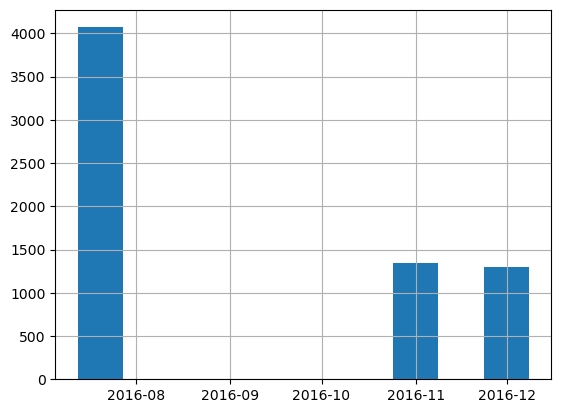

In [17]:
df["Request timestamp"].hist()

Indeed, we would ideally like to have collected data over a longer time period.

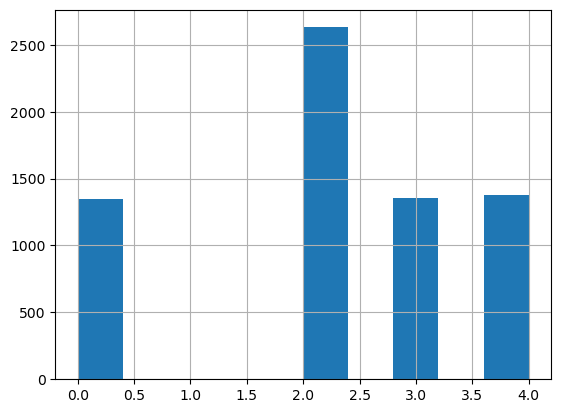

In [18]:
df["Weekday"].hist();

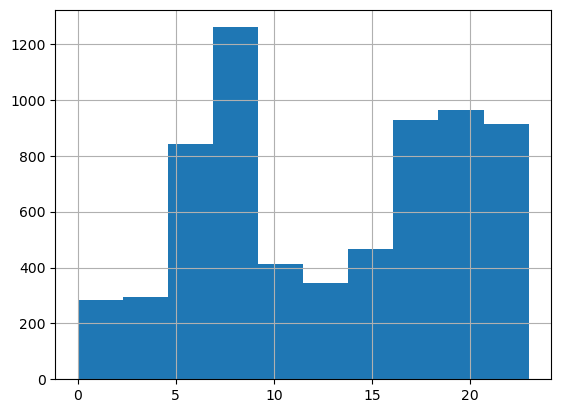

In [19]:
df["Hour"].hist();

Most rides are requested during the mornings (between 5am and 9am) and evenings (between 4 and 11pm). We will split this between airport and city:

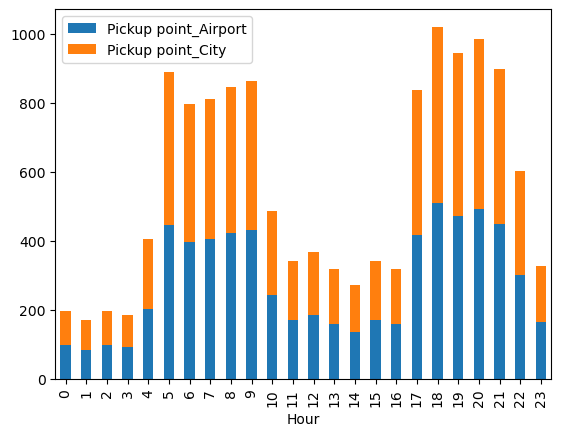

In [20]:
df1 = pd.get_dummies(df,columns=["Pickup point"])
df1.groupby(["Hour"]).agg({"Pickup point_Airport":"count","Pickup point_City":"count"}).plot(kind="bar",stacked=True);

In [21]:
df.groupby("Weekday")["Ride length"].mean()

Weekday
0   0 days 00:52:13.092783505
2   0 days 00:52:20.195381882
3   0 days 00:52:22.188679245
4   0 days 00:52:38.395721925
Name: Ride length, dtype: timedelta64[ns]

In [22]:
df.groupby("Hour")["Ride length"].mean()

Hour
0       0 days 00:53:46.500000
1       0 days 00:57:33.600000
2    0 days 00:53:09.729729729
3    0 days 00:51:15.882352941
4    0 days 00:54:13.076923076
5    0 days 00:51:32.756756756
6    0 days 00:54:01.437125748
7    0 days 00:52:37.931034482
8    0 days 00:50:52.645161290
9    0 days 00:53:24.277456647
10   0 days 00:52:18.620689655
11   0 days 00:53:23.478260869
12   0 days 00:52:28.760330578
13   0 days 00:50:33.707865168
14   0 days 00:51:39.545454545
15   0 days 00:53:27.058823529
16   0 days 00:52:23.736263736
17   0 days 00:51:53.245033112
18   0 days 00:50:43.902439024
19             0 days 00:51:30
20   0 days 00:52:51.055900621
21   0 days 00:52:42.253521126
22   0 days 00:53:08.289473684
23   0 days 00:49:52.602739726
Name: Ride length, dtype: timedelta64[ns]

It does not look like average ride lengths vary materially depending on weekday or time of day, which is surprising.

For further analysis we will convert the "Status" column into 3 columns:

In [23]:
df = pd.get_dummies(df,columns=["Status"])

### Analysis of cancellations and lack of car availability

In [24]:
df.groupby("Weekday").agg({"Status_Cancelled":"mean","Status_No Cars Available":"mean","Status_Trip Completed":"mean"})

,Status_Cancelled,Status_No Cars Available,Status_Trip Completed
Weekday,,,
0,0.194362,0.373887,0.431751
2,0.193843,0.378183,0.427974
3,0.186253,0.422025,0.391722
4,0.173787,0.419986,0.406227


No huge differences in average % of completed trips by weekday.

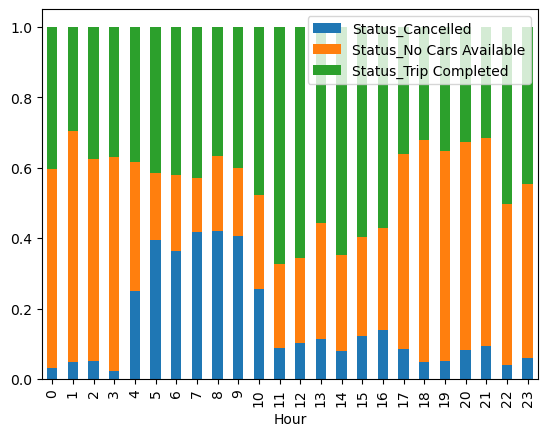

In [25]:
df.groupby("Hour").agg({"Status_Cancelled":"mean","Status_No Cars Available":"mean","Status_Trip Completed":"mean"}).plot(kind="bar",stacked=True);

This is more interesting: it looks like rides were most often not completed during the evening - between 5pm and 9pm due to lack of available cars. Rides were most often cancelled by the driver in the mornings, between 4am and 10am.

#### What differences can we see between trips starting at the airport and in the City?

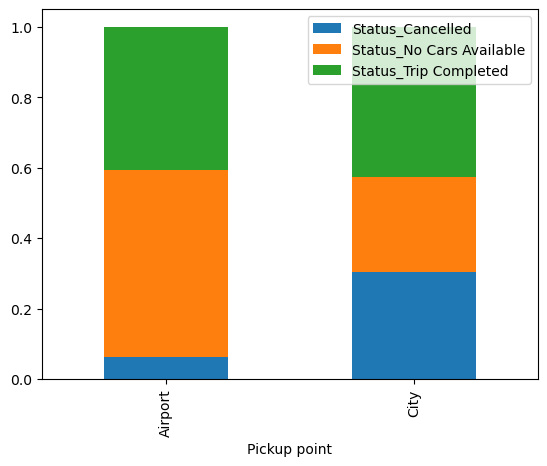

In [26]:
df.groupby("Pickup point").agg({"Status_Cancelled":"mean","Status_No Cars Available":"mean","Status_Trip Completed":"mean"}).plot(kind="bar",stacked=True);

Drivers cancelled rides much more often in the City, whilst the bigger problem at the airport was that cars weren't available. We are breaking this down by hour below:

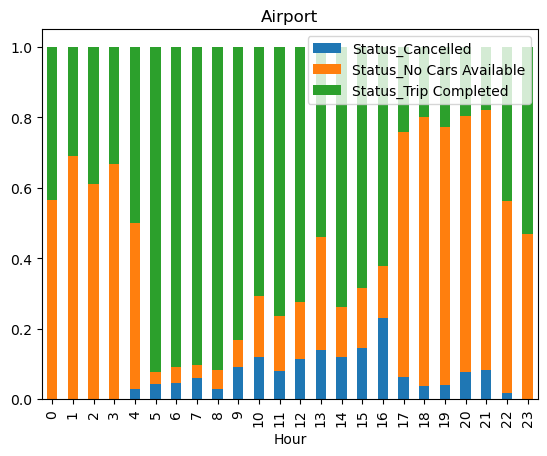

In [27]:
df[df["Pickup point"]=="Airport"].groupby(["Hour"]).agg({"Status_Cancelled":"mean","Status_No Cars Available":"mean","Status_Trip Completed":"mean"}).plot(kind="bar",stacked=True,title="Airport");

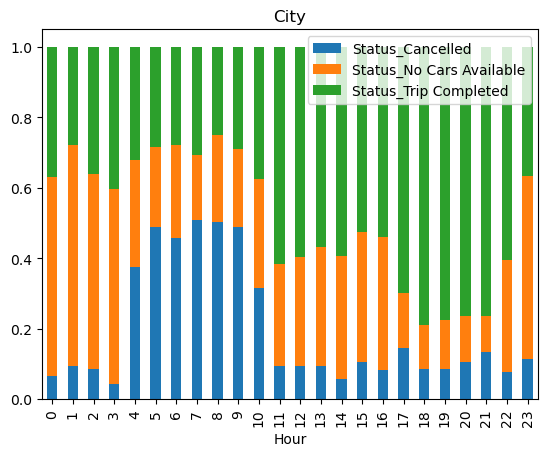

In [28]:
df[df["Pickup point"]=="City"].groupby(["Hour"]).agg({"Status_Cancelled":"mean","Status_No Cars Available":"mean","Status_Trip Completed":"mean"}).plot(kind="bar",stacked=True,title="City");

These two charts illustrate that at the airport, the biggest issue is lack of availability of cars in the evening between 5pm and 11pm (whilst lack of availability also looks like a problem between midnight and 4am, we know from our previous histogram that not many rides are requested during that time).
For trips from the City, the biggest issue appears to be cancellations during the morning (between 5am and 9.30am; again, we know from our histogram that not many rides are requested earlier in the morning). It seems likely that this is because plenty of "intra-city" trip requests are made during this time and drivers do not want to drive out.

Consequently, it might be ideal to try and encourage more "part-time drivers" to take up driving in the City in the mornings, and to encourage more drivers to the vicinity of the airport in the evenings - possibly through additional surcharges.